# Compare Auxtel Fitted Spectra and comparison with Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-02-23
- last update : 2024-02-23
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 

import h5py
from scipy import interpolate
from astropy.time import Time
import re
import seaborn as sns
import os

In [2]:
import matplotlib.ticker
%matplotlib inline
#%matplotlib ipympl

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
# SMOOTHING

def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


# Read pandas Series

In [5]:
files_spectra_dir = [ "./Data_Auxtel_Spectro/selected_29jan-15feb2024/spectra_transmission_ratio_N149.85"]
def get_spectra_path(nightobs):
    return files_spectra_dir[0]


In [6]:

files = [ "Data_Auxtel_Spectro/selected_29jan-15feb2024/out_allfittedparams_selected_29jan-15feb2024_N149.85.csv", 
        ]
N = len(files)

In [7]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [8]:
df = pd.concat(all_df)

In [9]:
df.head()

,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,ROTANGLE,...,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y,filtered
DATE-OBS,,,,,,,,,,,,,,,,,,,,,
2024-01-30 01:12:10.133003850+00:00,2024012900294,-64,2,1059,3,True,HD38666,0.000364,holo4_003,0.189044,...,0.662450,1.010570,0.419342,182.085360,0.025198,-2.000000,0.0,0.0,0.0,False
2024-01-30 01:56:23.335993153+00:00,2024012900323,-64,2,1059,3,True,HD185975,-0.000065,holo4_003,0.134970,...,0.041638,1.616518,0.026414,187.806980,0.004137,1.847606,0.0,0.0,0.0,False
2024-01-30 01:57:36.253501409+00:00,2024012900324,-64,2,1059,3,True,HD185975,-0.000065,holo4_003,0.153747,...,0.043881,1.282444,0.102622,182.040419,0.010007,-2.000000,0.0,0.0,0.0,False
2024-01-30 02:05:33.581508530+00:00,2024012900330,-64,2,1059,3,True,HD2811,0.000000,holo4_003,0.133953,...,0.060414,1.024475,0.038779,187.818319,0.004184,1.846727,0.0,0.0,0.0,True
2024-01-30 02:06:46.604509935+00:00,2024012900331,-64,2,1059,3,True,HD2811,0.000000,holo4_003,0.124950,...,0.080177,1.020508,0.035054,187.877022,0.005169,1.823197,0.0,0.0,0.0,True


In [10]:
for name in list(df.columns):
    print(name)

id
BITPIX
NAXIS
NAXIS1
NAXIS2
EXTEND
TARGET
REDSHIFT
GRATING
ROTANGLE
D2CCD
LSHIFT
PARANGLE
TARGETX
TARGETY
LBDA_REF
PSF_REG
TRACE_R
MEANFWHM
PIXSHIFT
CHI2_FIT
A2_FIT
AM_FIT
VERSION
REBIN
CONFIG
EXPTIME
AIRMASS
DEC
HA
OUTTEMP
OUTPRESS
OUTHUM
FILTER
CAM_ROT
S_X0
S_Y0
S_XMIN
S_XMAX
S_YMIN
S_YMAX
S_NX
S_NY
S_DEG
S_SAT
S_ORDER
A1_x
A1_err_x
A2_x
A2_err_x
A3
A3_err
VAOD_x
VAOD_err_x
angstrom_exp_x
angstrom_exp_err_x
ozone [db]_x
ozone [db]_err_x
PWV [mm]_x
PWV [mm]_err_x
D_CCD [mm]_x
D_CCD [mm]_err_x
shift_x [pix]
shift_x [pix]_err
shift_y [pix]
shift_y [pix]_err
angle [deg]
angle [deg]_err
B_x
B_err_x
x_c_0_1
x_c_0_1_err
x_c_1_1
x_c_1_1_err
x_c_2_1
x_c_2_1_err
y_c_0_1
y_c_0_1_err
y_c_1_1
y_c_1_1_err
y_c_2_1
y_c_2_1_err
gamma_0_1
gamma_0_1_err
gamma_1_1
gamma_1_1_err
gamma_2_1
gamma_2_1_err
alpha_0_1
alpha_0_1_err
alpha_1_1
alpha_1_1_err
alpha_2_1
alpha_2_1_err
saturation_0_1
saturation_0_1_err
x_c_0_2
x_c_0_2_err
x_c_1_2
x_c_1_2_err
x_c_2_2
x_c_2_2_err
y_c_0_2
y_c_0_2_err
y_c_1_2
y_c_1_2_e

In [11]:
def convertNumToDatestr(num):
    year = num//1000_000_000
    month= (num-year*1000_000_000)//10_000_000
    day = (num-year*1000_000_000-month*10_000_000)//100_000

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)
    #return datestr

In [12]:
print(df.id.values)

[2024012900294 2024012900323 2024012900324 2024012900330 2024012900331
 2024013100293 2024013100294 2024020500033 2024020500034 2024020500040
 2024020500041 2024020600174 2024020600187 2024020600201 2024020600202
 2024020600209 2024020600226 2024020600227 2024020600240 2024020600282
 2024020600283 2024020600350 2024020600351 2024020700405 2024020700411
 2024020700412 2024020700444 2024021200420 2024021200421 2024021200458
 2024021200465 2024021200466 2024021200472 2024021200479 2024021200480
 2024021200526 2024021200527 2024021200593 2024021200594 2024021300094
 2024021300095 2024021300102 2024021300108 2024021300115 2024021300124
 2024021300137 2024021300138 2024021300151 2024021300152 2024021300165
 2024021300182 2024021300183 2024021300217 2024021300276 2024021300277
 2024021400068 2024021400075 2024021400076 2024021400087 2024021400101
 2024021400102 2024021400115 2024021400116 2024021400129 2024021400130
 2024021400136 2024021400137 2024021900247 2024021900248 2024021900334
 20240

In [13]:
df['nightobs'] = df.id.values//100_000

In [14]:
df['dateobs']=[convertNumToDatestr(num) for num in df.id.values ]

## Remove non Photometric Nights

In [15]:
NonPhotometricNights = [20240131]

In [16]:
PhotometricNightSelector  = lambda x : True if x not in NonPhotometricNights else False

In [17]:
df['PhotometricNight_Flag'] = df['nightobs'].apply(PhotometricNightSelector)

In [18]:
df = df[df['PhotometricNight_Flag']].drop(['PhotometricNight_Flag'],axis=1)

## Check Spectra quality

In [19]:
df1 = df
#df2 = df[(df['nightobs']>=20230301) & (df['nightobs']<=20230914)]
#df3 = df[(df['nightobs']>=20230927) & (df['nightobs']<=20231207)]

In [20]:
print("df1 : ",df1.nightobs.unique())
#print("df2 : ",df2.nightobs.unique())
#print("df3 : ",df3.nightobs.unique())

df1 :  [20240129 20240205 20240206 20240207 20240212 20240213 20240214 20240219
 20240220]


In [21]:
def get_all_data_fromhf(hf):

    def get_attrs(name,obj):
        d = {}
        for key, val in obj.attrs.items():
            d[key] = val
        return d
    
    all_attributes = {}
    all_datasets = {}
    list_of_keys = list(hf.keys())

    # loop on each key of top level groups
    for key in list_of_keys: 
        group = hf.get(key)
    
        # retrieve all attributes for each group
        all_attributes[key] = get_attrs(key,group)

        datasets = {}
        for name, h5obj in group.items():
            if isinstance(h5obj,h5py.Group):
                pass
                # just check if there are subgroups that would need to be red recursively
                #print("\t >>> ",key,' / ',name,'is a Group')
         
            elif isinstance(h5obj,h5py.Dataset):
                #print("\t >>> ", key , name,'is a Dataset')
                arr = h5obj[:]
                #arr = hf[name][:] # same thing
                # add that dataset to the current group datasets
                datasets[name] = arr
    
        all_datasets[key] = datasets  
    return  list_of_keys, all_attributes ,all_datasets

In [22]:
def ShowDCCD(hf,nightobs,df_in):
    """
    """
    dfi = df_in.copy()
    
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        tag = re.findall("^spec_(.*)", spec_num)[0]
        tag= int(tag)
       
        the_DCCD = dfi[dfi["id"] == tag ]['D_CCD [mm]_y'].values[0]
        print(spec_num,nightobs,DATEOBS_STR,the_DCCD)

In [23]:
df_subset = df[["id","D_CCD [mm]_y"]]

In [24]:
df_subset[df_subset["id"] == 2024012900323]["D_CCD [mm]_y"].values[0]

187.806980487164

In [25]:
df_subset.copy()

,id,D_CCD [mm]_y
DATE-OBS,,
2024-01-30 01:12:10.133003850+00:00,2024012900294,182.085360
2024-01-30 01:56:23.335993153+00:00,2024012900323,187.806980
2024-01-30 01:57:36.253501409+00:00,2024012900324,182.040419
2024-01-30 02:05:33.581508530+00:00,2024012900330,187.818319
2024-01-30 02:06:46.604509935+00:00,2024012900331,187.877022
...,...,...
2024-02-21 03:54:55.520490181+00:00,2024022000416,186.153089
2024-02-21 03:56:08.537491021+00:00,2024022000417,181.460729
2024-02-21 04:20:21.040492909+00:00,2024022000431,188.081303


In [26]:
for nightobs in df1.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
  
    hf = h5py.File(fullfilename, 'r')
    ShowDCCD(hf,nightobs,df_subset.copy())
    hf.close()

spec_2024012900330 20240129 2024-01-29 187.8183188472099
spec_2024012900331 20240129 2024-01-29 187.8770222491381
spec_2024020500034 20240205 2024-02-05 186.4889771335101
spec_2024020500041 20240205 2024-02-05 188.4339494515527
spec_2024020600201 20240206 2024-02-06 186.9433868175342
spec_2024020600202 20240206 2024-02-06 186.4522729046905
spec_2024020600282 20240206 2024-02-06 185.7725604015971
spec_2024020600283 20240206 2024-02-06 186.07285456596543
spec_2024020600350 20240206 2024-02-06 186.9352064124315
spec_2024020700405 20240207 2024-02-07 182.14298977018552
spec_2024020700411 20240207 2024-02-07 182.0009994506836
spec_2024020700412 20240207 2024-02-07 187.8448919282022
spec_2024021200421 20240212 2024-02-12 187.76097056318272
spec_2024021200526 20240212 2024-02-12 187.79987678252448
spec_2024021200527 20240212 2024-02-12 187.80336769461076
spec_2024021200593 20240212 2024-02-12 187.7210414154036
spec_2024021200594 20240212 2024-02-12 187.8111133631033
spec_2024021300094 2024021

In [27]:
def PlotTransmission(hf,nightobs,df_in):

    dfi = df_in.copy()
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        tag = re.findall("^spec_(.*)", spec_num)[0]
        tag= int(tag)
        the_DCCD = dfi[dfi.id == tag ]['D_CCD [mm]_y'].values[0]
        print(spec_num,the_DCCD)
        info = f"{nightobs} :: {spec_num} , tg = {the_target} Dccd = {the_DCCD:.2f}"
        textstr2 = '\n'.join((textstr2,info))
        all_targets.append(the_target)
    
    targets_unique = np.unique(all_targets)
    Ntags = len(targets_unique )
    cmap = sns.color_palette("husl", Ntags)

    #text string
    atm = all_attributes['median_param_atm']
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((
    r'$PWV=%.3f$ mm' % (atm["md_PWV"], ),
    r'$ozone=%.1f$ DU' % (atm["md_ozone"], ),
    r'$VAOD=%.3f$' % (atm['md_VAOD'], )))
    
    # plot
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True)

    color_counts = np.zeros(Ntags)

    # loop on data
    for idx,spec_num in enumerate(spec_nums_list):
        the_dataset = all_datasets[spec_num]
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']

        the_label = the_target

        idxc = np.where(targets_unique== the_target )[0][0]
        the_col = cmap[idxc]
    
 
        all_targets.append(the_target)
        the_airmass = the_attrs['airmass']
        the_flag = the_attrs['flag_atmparam']
        the_title = f"{spec_num} , target = {the_target}"
    
   
        wls = the_dataset['wls']
        fls = the_dataset['fls']
        fls_err = the_dataset['fls_err']

        ratio_airmass1 = the_dataset['ratio_airmass1']
        wlr = the_dataset['wlr']

        span=3
        ratio_airmass2 = smooth_data_np_convolve(ratio_airmass1,span)
        
        if color_counts[idxc] == 0:
            ax1.plot(wls,fls,'-', color= the_col,label = the_label)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col,label=the_label)
            color_counts[idxc] = color_counts[idxc]+1
        else:
            ax1.plot(wls,fls,'-', color= the_col)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col)
            color_counts[idxc] = color_counts[idxc]+1

        
    # the simulation
    the_sim = all_datasets['sim_spec']
    transm = the_sim["transm"] 
    wls = the_sim["wls"] 
    ax2.plot(wls,transm,'k',label="simulation")
    ax2.text(0.75, 0.25, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
   
    ax2.set_ylim(0.,1.2)  
    ax1.legend()  
    ax2.legend()
    ax1.set_title(f"{DATEOBS_STR}")
    ax1.set_xlim(370.,980.)
    ax2.set_xlabel("wavelength (nm)")
    ax1.set_ylabel("flux (ergs/cm$^2$/s/nm)")
    ax2.set_ylabel("atmospheric transmission")
    ax1.text(1.1, 1.0, textstr2, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        #plt.tight_layout()
    ax1.grid()
    ax2.grid()
    plt.subplots_adjust(wspace=None, hspace=0)
    plt.show()

### Check quality in nights in df1 

spec_2024012900330 187.8183188472099
spec_2024012900331 187.8770222491381


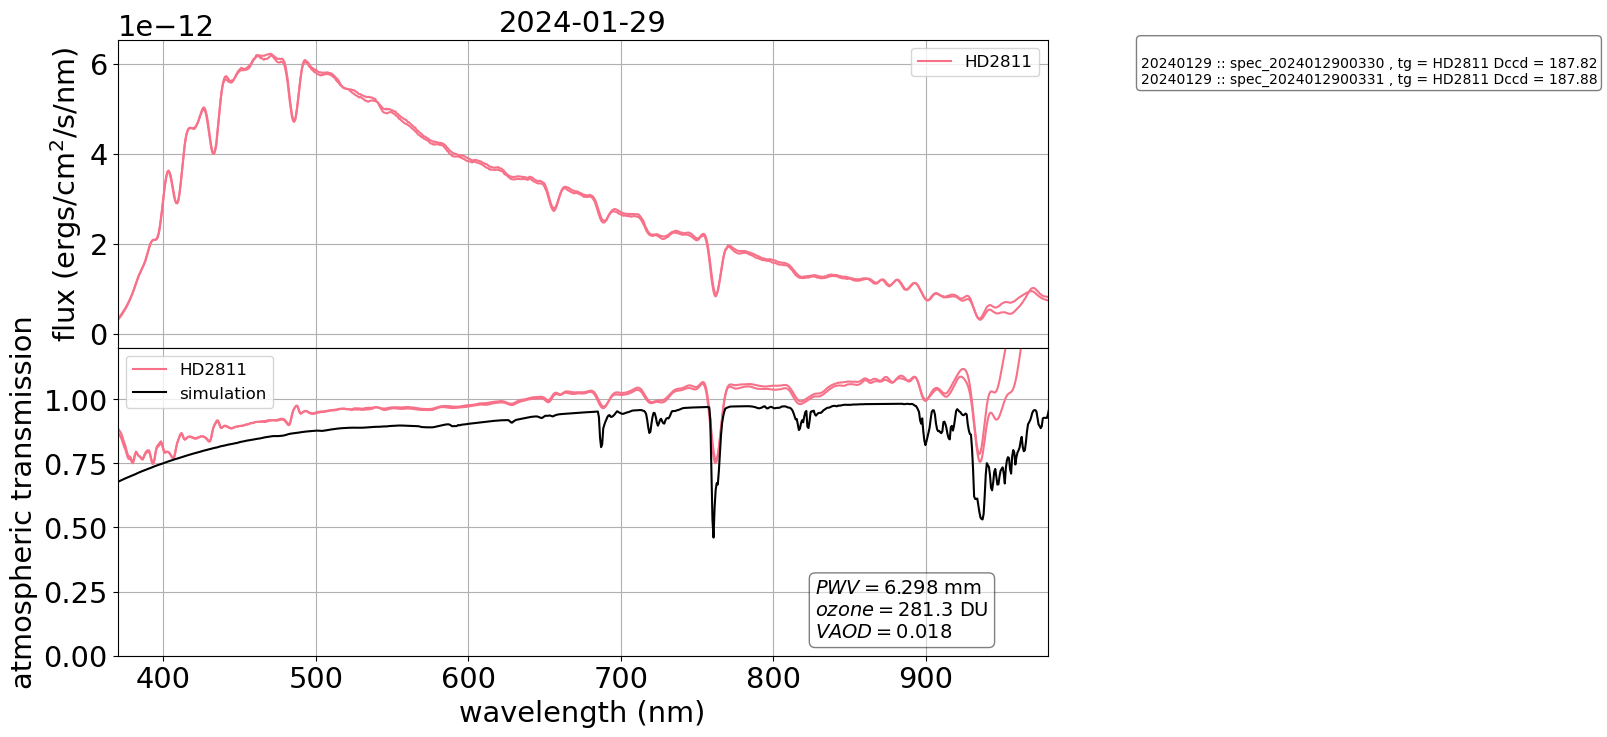

spec_2024020500034 186.4889771335101
spec_2024020500041 188.4339494515527


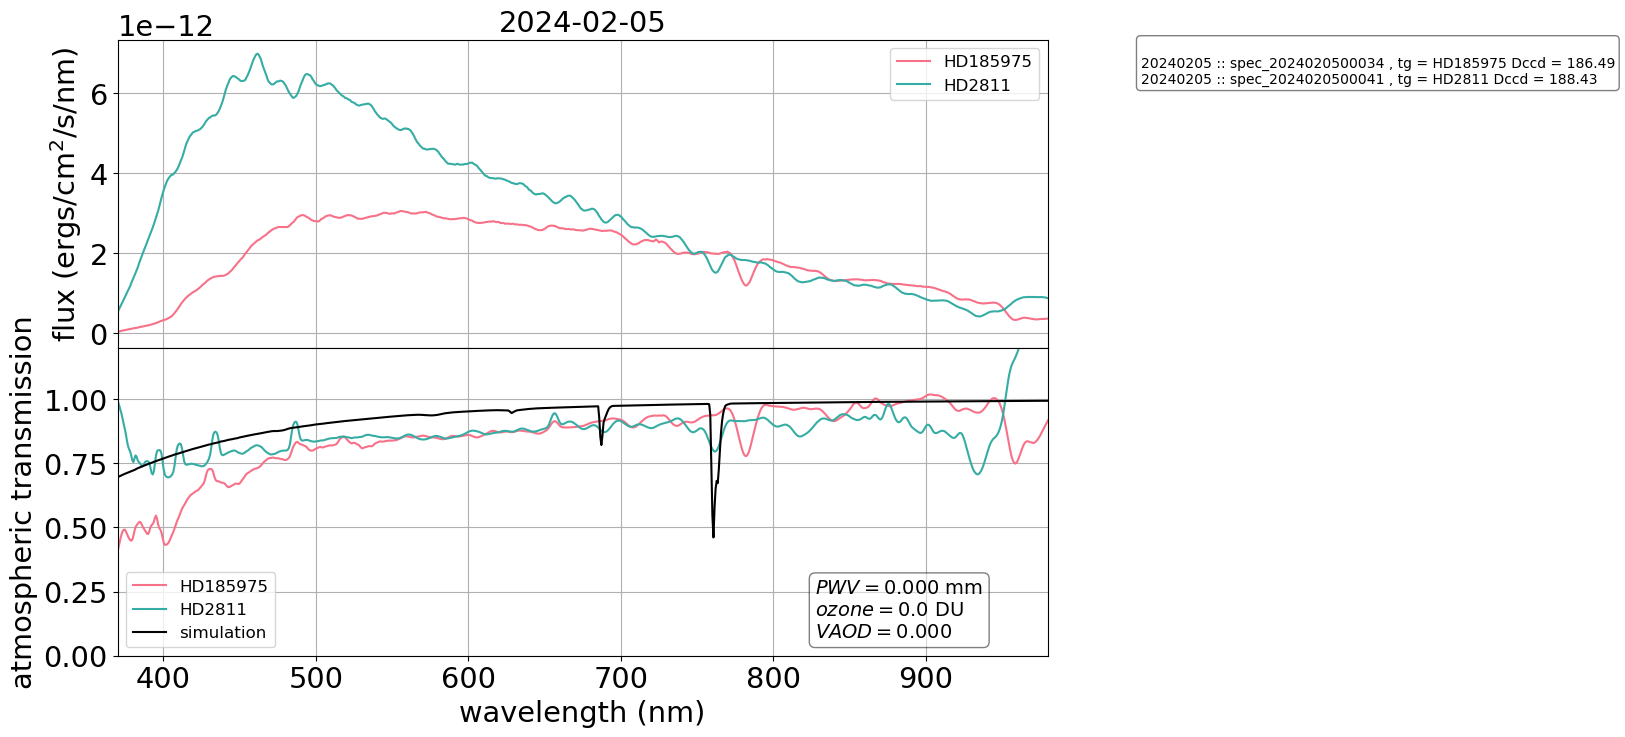

spec_2024020600201 186.9433868175342
spec_2024020600202 186.4522729046905
spec_2024020600282 185.7725604015971
spec_2024020600283 186.07285456596543
spec_2024020600350 186.9352064124315


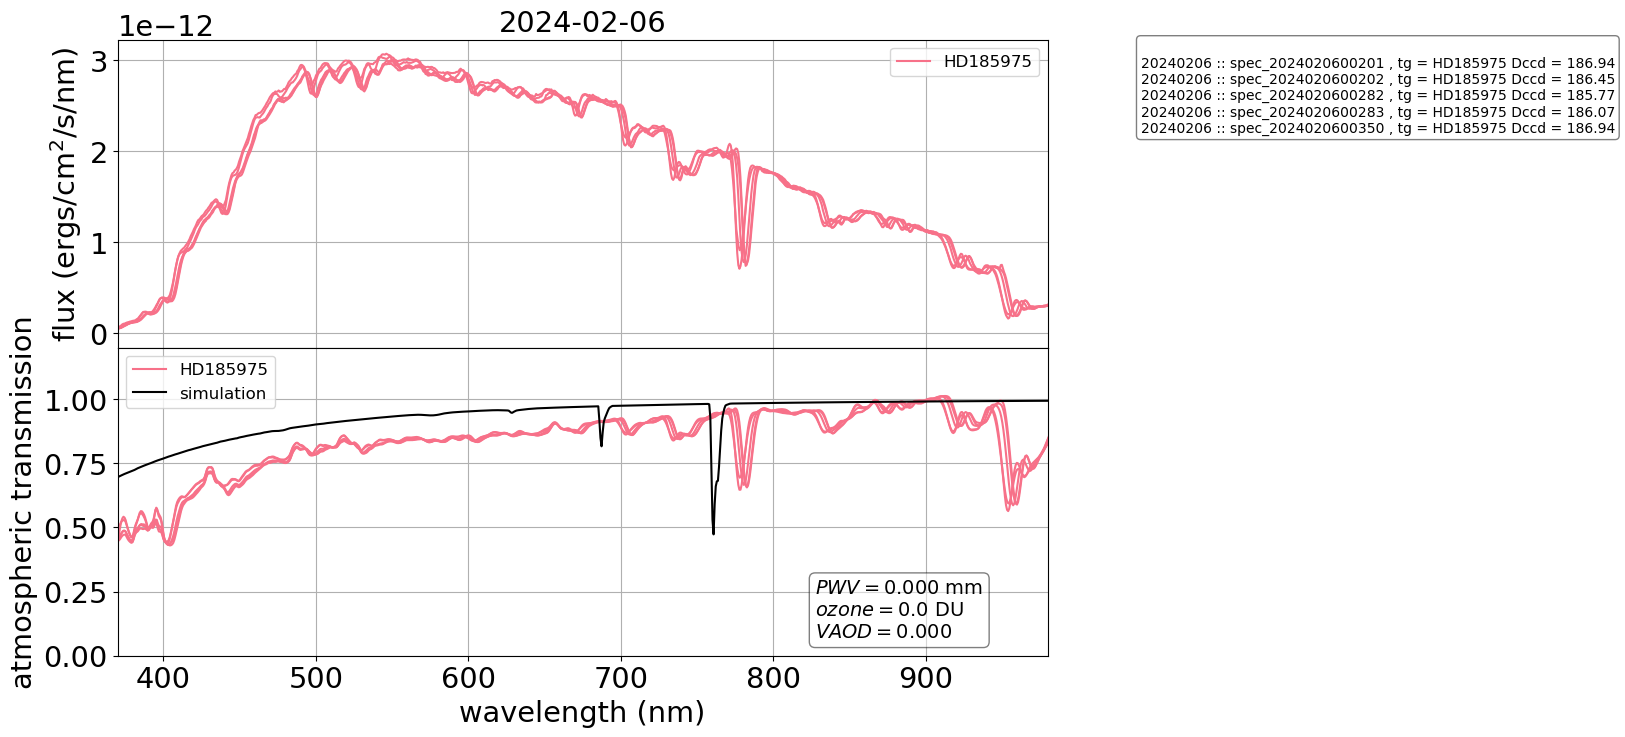

spec_2024020700405 182.14298977018552
spec_2024020700411 182.0009994506836
spec_2024020700412 187.8448919282022


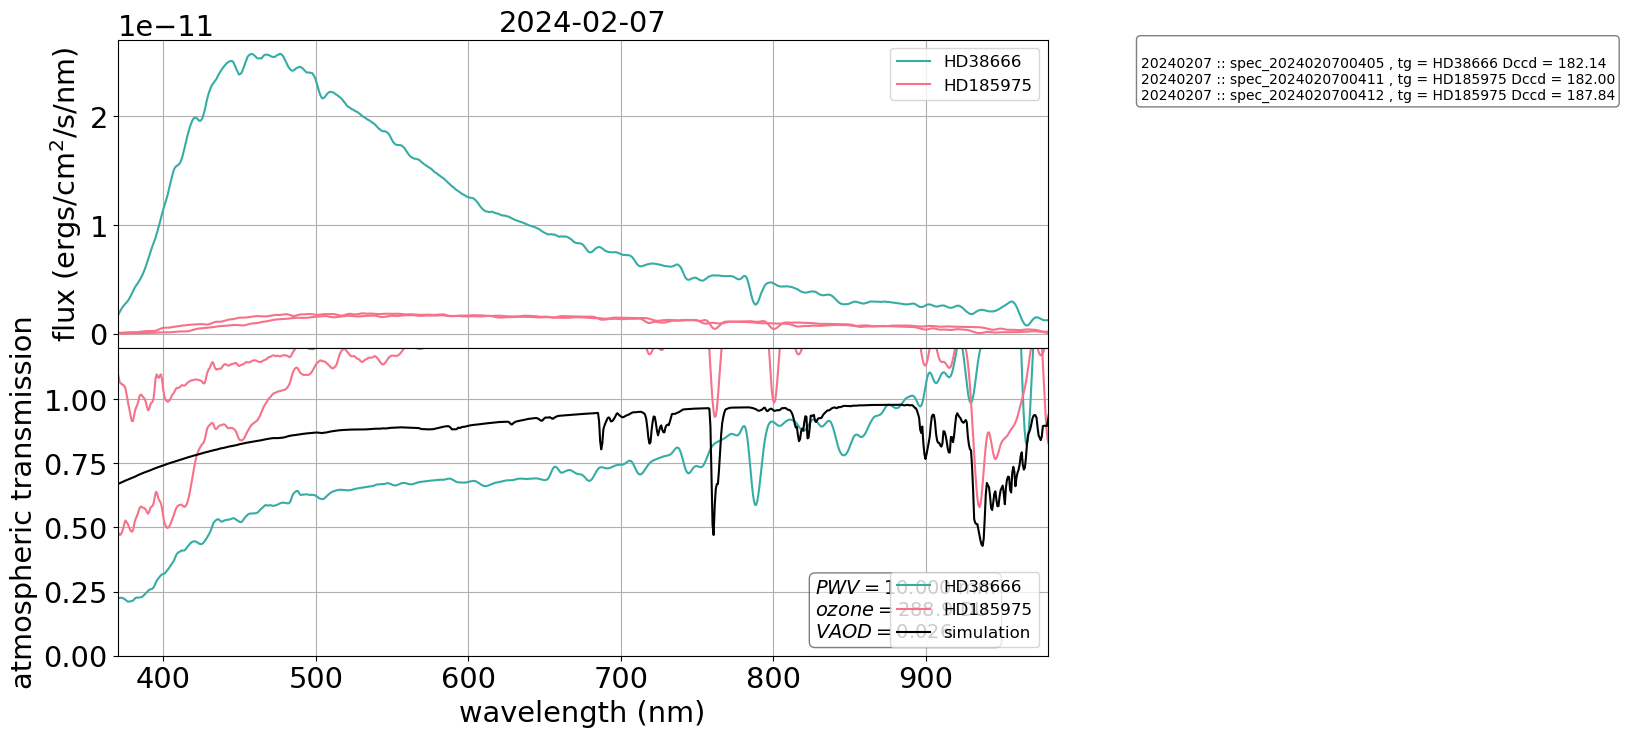

spec_2024021200421 187.76097056318272
spec_2024021200526 187.79987678252448
spec_2024021200527 187.80336769461076
spec_2024021200593 187.7210414154036
spec_2024021200594 187.8111133631033


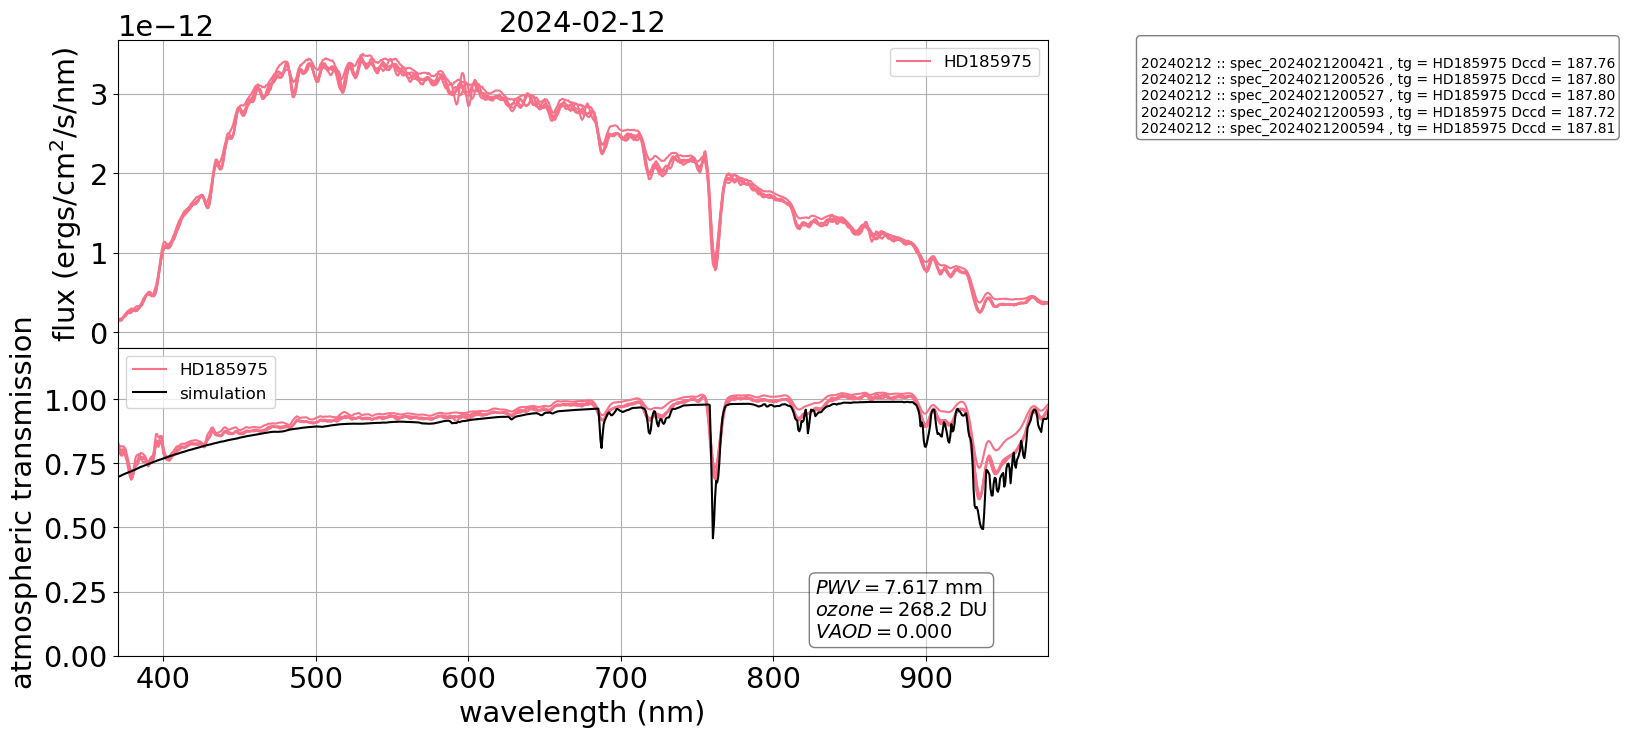

spec_2024021300094 188.02305125220096
spec_2024021300108 188.0033329825131
spec_2024021300124 188.05856636726995
spec_2024021300151 187.83914101194569
spec_2024021300152 189.9833531419304
spec_2024021300182 181.88113078860877
spec_2024021300183 183.3916415485513


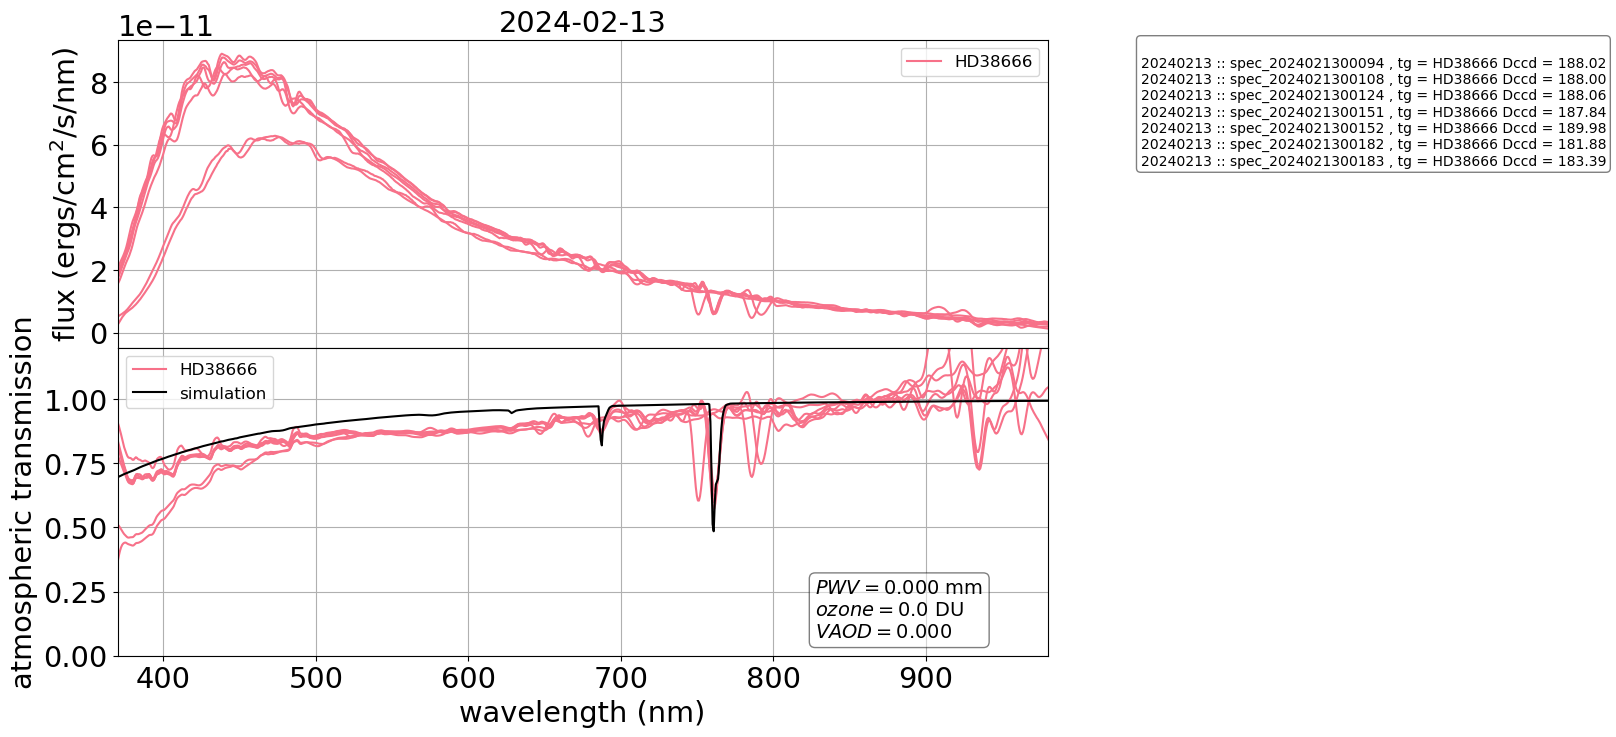

spec_2024021400068 187.80283957466156
spec_2024021400076 184.50947591691929
spec_2024021400101 184.01733925324316
spec_2024021400102 187.9919877170112
spec_2024021400115 185.02969510420996
spec_2024021400130 187.8733419024091
spec_2024021400136 184.29089049171336
spec_2024021400137 184.0799161831005


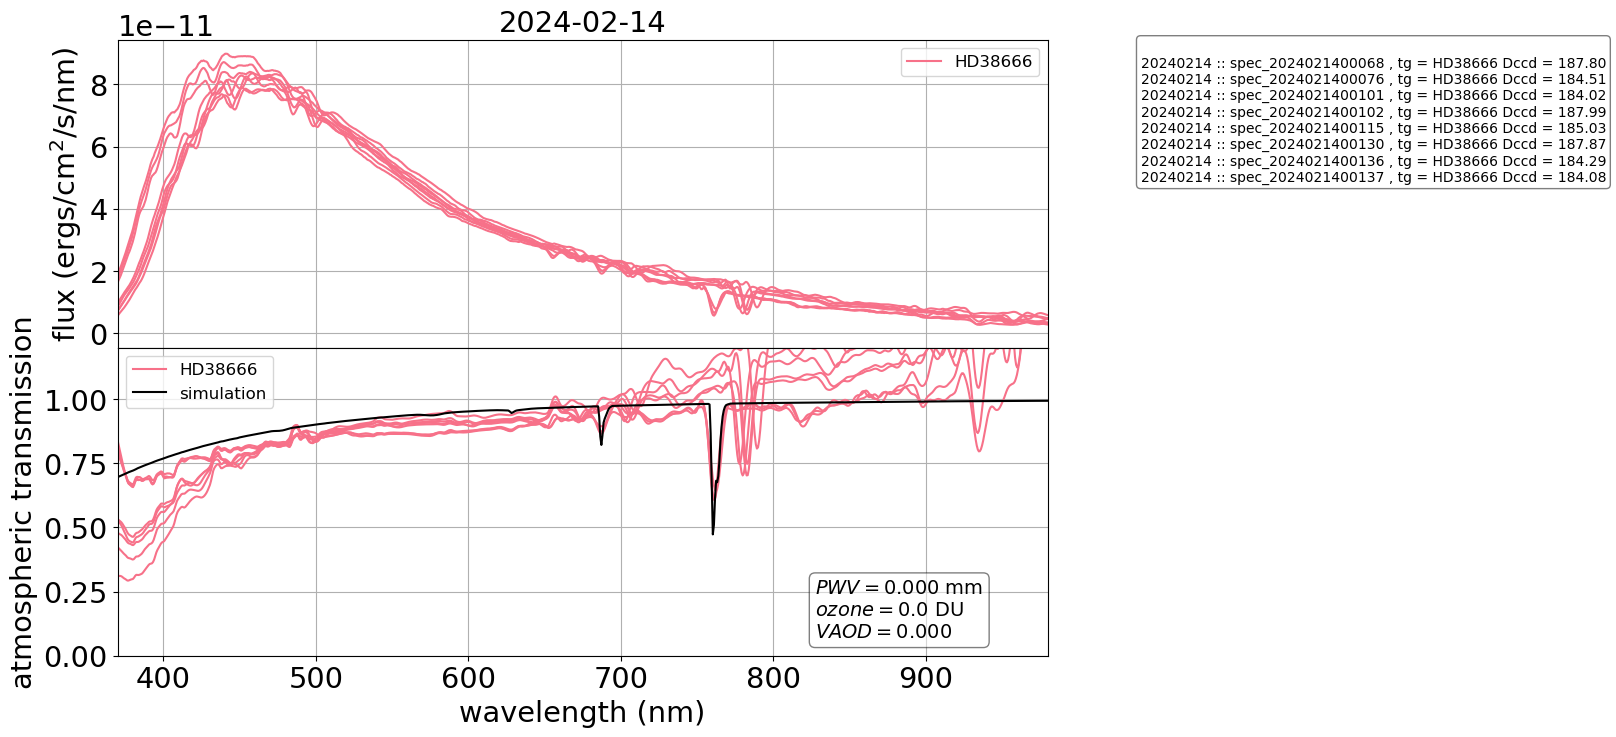

spec_2024021900248 180.0251270050397
spec_2024021900403 180.00084667689418
spec_2024021900404 182.37692961345817
spec_2024021900410 182.1814501979867
spec_2024021900417 181.09126852571669
spec_2024021900431 182.564650100394


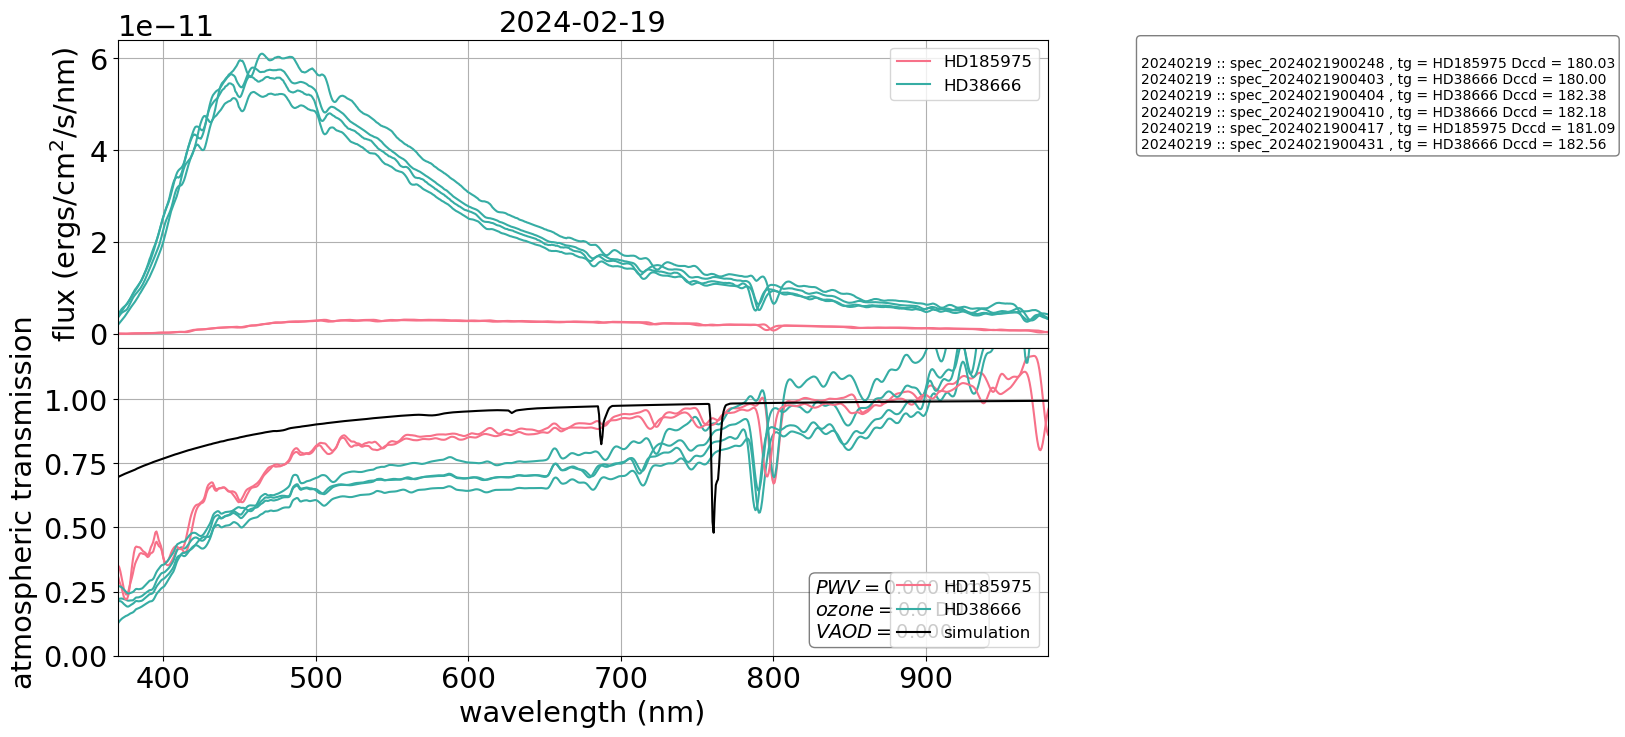

spec_2024022000379 188.00109271384235
spec_2024022000409 188.0050055865284
spec_2024022000431 188.0813028487824
spec_2024022000444 188.0015516158313
spec_2024022000445 187.9978592594583


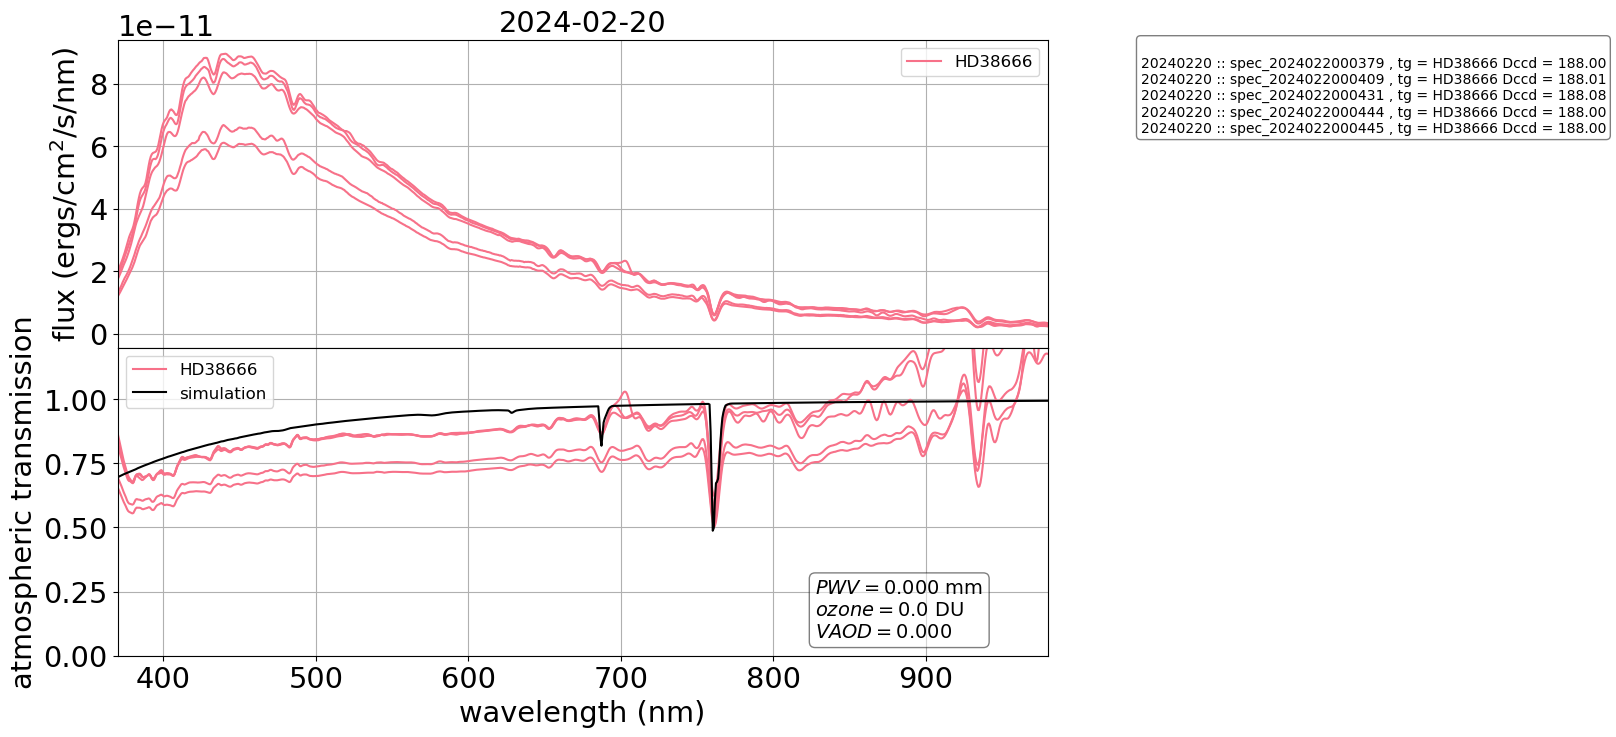

In [28]:
for nightobs in df1.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs,df)
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

# NO DF2

In [ ]:
assert False

### Quality night in df2

In [29]:
for nightobs in df2.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs)
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

NameError: name 'df2' is not defined

In [ ]:
for nightobs in df3.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs)
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

                         # but may be overridden in exception subclasses

## Apply quality cuts

In [ ]:
cut = df["FILTER"] == "empty"
df = df[cut]

In [ ]:
# convert pandas to numpy rec array
rec = df.to_records()

In [ ]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

In [ ]:
stars = np.unique(rec["TARGET"])
stars

In [ ]:
filters = np.unique(rec["FILTER"])
filters

## Plot

In [ ]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.5,1.5]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

In [ ]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [ ]:
top_merra2 = "../../../Merra2"

In [ ]:
asm_merra2 = [
    #"MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
    #"MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [ ]:
aer_merra2 = [
    #"MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
    #"MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [ ]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [ ]:
df_asm[0].head()

In [ ]:
df_aer[0].head()

In [ ]:
df_asm[0].index

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")



In [ ]:
df["dateobs"].values

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")

## Ozone

In [ ]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-',label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    ax.set_xlim(pd.to_datetime('2023-08-01 00:00:00'),pd.to_datetime('2024-01-01 00:00:00'))
    ax.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## PWV

In [ ]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5,label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    ax.set_xlim(pd.to_datetime('2023-08-01 00:00:00'),pd.to_datetime('2024-01-01 00:00:00'))
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2024"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()